In [1]:
import torch
from pathlib import Path

from doodle_dataset import DoodleDataset
from doodle_parsing_utils import *
from doodle_predictor import DoodlePredictor, calculate_loss
from doodle_predictor_config import DoodlePredictorConfig
from doodle_dataset import encode_stroke_data, decode_stroke_data

In [2]:
config = DoodlePredictorConfig("./configs/base_config.json")
doodle_predictor = DoodlePredictor(config).to(config.device)

In [4]:
doodle_predictor.load_state_dict(torch.load("./models/bigger_embeds/model_state_dict"))

<All keys matched successfully>

In [5]:
test_dataset = DoodleDataset(
    Path("./dataset"),
    split="test",
    block_size=config.block_size - 1,
    device=config.device,
)

Preprocessing Data:


1it [00:00, 54.98it/s]

Calculating CLIP Embeddings


In [ ]:
def complete_doodle(doodle: torch.Tensor, classname_embedding: torch.Tensor, max_strokes=50):
    full_doodle = doodle.clone().to(config.device)

    num_additional_strokes = 0
    doodle_finished = False
    while num_additional_strokes <= max_strokes or doodle_finished:
        new_stroke = doodle_predictor(
            full_doodle[num_additional_strokes:].unsqueeze(0).to(config.device).float(),
            classname_embedding.unsqueeze(0).to(config.device).float()
        )[0, -1, :]

        # Decode the one-hot pen state
        new_stroke[2:] = new_stroke[2:] == torch.max(new_stroke[2:])
        new_stroke = new_stroke.unsqueeze(0).to(config.device)

        full_doodle = torch.cat([full_doodle, new_stroke])

        doodle_finished = new_stroke[0, -1].item()
        num_additional_strokes += 1
    
    return full_doodle

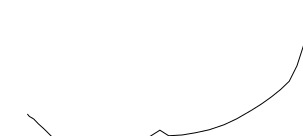

In [7]:
xs, ys, classname_embedding = test_dataset[100]
full_doodle = complete_doodle(xs, classname_embedding)
decoded_doodle = decode_stroke_data(full_doodle.detach().cpu())
draw_strokes(decode_stroke_data(xs), factor=5)

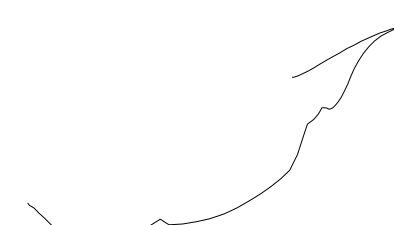

In [8]:
draw_strokes(decoded_doodle, factor=5)

# NOTE: WE REALLLLLY NEED TO INCREASE THE WEIGHTING ON THE FIRST TWO TERMS

In [9]:
calculate_loss(full_doodle[1:32].unsqueeze(0).to(config.device), ys.unsqueeze(0).to(config.device), config.position_loss_coeff, config.pen_state_loss_coeff)

tensor(2.4302, device='cuda:0', dtype=torch.float64, grad_fn=<AddBackward0>)

In [96]:
full_doodle[1:32].shape, ys.shape

(torch.Size([31, 5]), torch.Size([31, 5]))